**In this file**, we optimize the step schedule by using SGD on the space of schedules.


In [ ]:
import numpy as np
import scipy as sp
from scipy.sparse import linalg as splinalg
from scipy.signal import fftconvolve as fftconvolve
from scipy.integrate import quad
from scipy.integrate import solve_ivp

import tensorflow as tf
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import bisect

#Generate eigenvalues
Generate a synthetic set of eigenvalues.  The eigenvalues should be normalized to have average value 1. **These are then passed to the script below to generate the synthetic loss** (both ''n'' and ''eigs'').  

The multiple scales in the example just below seem to provide interesting results.  Log-normal + signal is common in image datasets.

The eigenvalues are normalized to have average value 1.

(array([5995., 1183.,  822.,    0.,    0.,    0.,    0.,    0.,   27.,
          66.,   33.,   46.,   52.,   37.,   35.,   47.,   46.,   46.,
          47.,   46.,   59.,   45.,   42.,   40.,   42.,   49.,   62.,
          40.,   49.,   43.,   52.,   56.,   57.,   43.,   49.,   58.,
          56.,   48.,   56.,   58.,   58.,   52.,   44.,   49.,   47.,
          46.,   44.,   47.,   47.,   34.]),
 array([1.90229355e-04, 1.59051558e-01, 3.17912886e-01, 4.76774214e-01,
        6.35635543e-01, 7.94496871e-01, 9.53358200e-01, 1.11221953e+00,
        1.27108086e+00, 1.42994218e+00, 1.58880351e+00, 1.74766484e+00,
        1.90652617e+00, 2.06538750e+00, 2.22424883e+00, 2.38311016e+00,
        2.54197148e+00, 2.70083281e+00, 2.85969414e+00, 3.01855547e+00,
        3.17741680e+00, 3.33627813e+00, 3.49513945e+00, 3.65400078e+00,
        3.81286211e+00, 3.97172344e+00, 4.13058477e+00, 4.28944610e+00,
        4.44830742e+00, 4.60716875e+00, 4.76603008e+00, 4.92489141e+00,
        5.08375274e+00, 

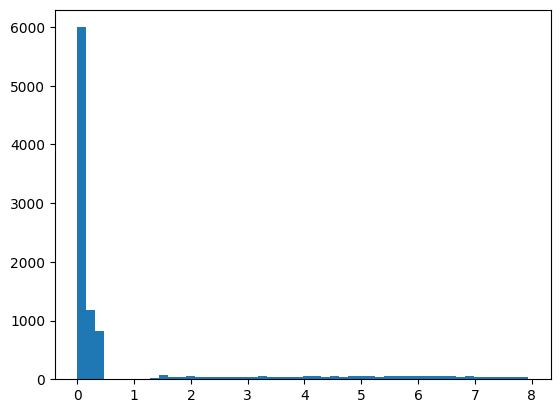

In [ ]:
n = 10000 #datapoints to keep
eigs = np.zeros(n)

a1 = np.random.randn(6000)-7.0
a2 = np.random.uniform(0.03,0.06,2000)
a3 = np.random.uniform(0.2,1.2,2000)
a1 = np.exp(a1)
eigs[0:2000]=a2
eigs[2000:4000]=a3
eigs[4000:10000]=a1
l=np.sum(eigs)
eigs=eigs*n/l
plt.hist(eigs,bins=50)

#**Alternative to the above,** the cell below just makes a square marchenko-pastur

(array([898., 368., 279., 234., 203., 181., 166., 152., 140., 132., 124.,
        117., 110., 104., 101.,  94.,  91.,  88.,  83.,  78.,  76.,  75.,
         70.,  68.,  65.,  63.,  60.,  59.,  53.,  53.,  50.,  49.,  48.,
         44.,  43.,  41.,  38.,  37.,  34.,  33.,  31.,  29.,  26.,  23.,
         23.,  19.,  17.,  14.,  11.,   5.]),
 array([4.80065763e-09, 8.02675647e-02, 1.60535125e-01, 2.40802685e-01,
        3.21070244e-01, 4.01337804e-01, 4.81605364e-01, 5.61872924e-01,
        6.42140484e-01, 7.22408044e-01, 8.02675604e-01, 8.82943164e-01,
        9.63210724e-01, 1.04347828e+00, 1.12374584e+00, 1.20401340e+00,
        1.28428096e+00, 1.36454852e+00, 1.44481608e+00, 1.52508364e+00,
        1.60535120e+00, 1.68561876e+00, 1.76588632e+00, 1.84615388e+00,
        1.92642144e+00, 2.00668900e+00, 2.08695656e+00, 2.16722412e+00,
        2.24749168e+00, 2.32775924e+00, 2.40802680e+00, 2.48829436e+00,
        2.56856192e+00, 2.64882948e+00, 2.72909704e+00, 2.80936460e+00,
        2.

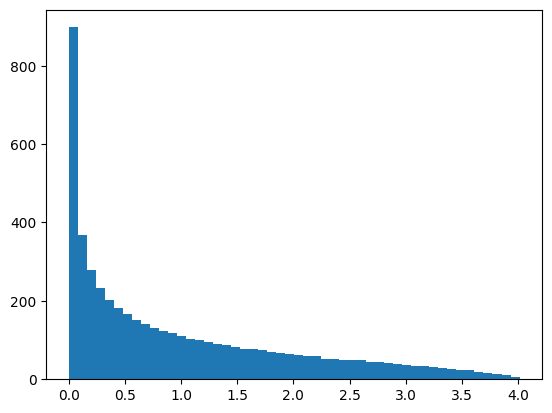

In [ ]:
n = 5000 #datapoints to keep
eigs = np.zeros(n)

A = np.random.randn(n,n)
s = np.linalg.svd(A,compute_uv=False)
eigs = s**2
l=np.sum(eigs)
eigs=eigs*n/l
plt.hist(eigs,bins=50)

#Schedule optimizer
This routine optimizes over all schedules $\Gamma$, using the objective function $\Psi_T$ for some fixed $T$.  This is done using a stochastic gradient descent on piecewise constant inverse schedule densities $w$.  The inverse schedule density is $w(s) = \frac{d}{ds}\Gamma^{-1}(s)$.  This is convenient as performing the optimization in $w$ uses convolution volterra equations.

The script takes as input $n$ and $eigs$.  It generates a gradient flow loss (time series vector "input_loss") as if it was solving for an isotropic normal target (as if it were interpolating pure noise).  If another gradient flow input were provided, it could run with this as well.

Some implementation notes:

* In the implementation, it is assumed that no more than $R=2T$ amount of gradient flow time is used (if the trace of the hessian is 1, this will always be satisfied)

* To improve the look, a regularizer is added to the loss, $\epsilon\int_0^t\|\dot{w}\|^2$ (or rather its discrete analogue).

* Time is discretized to bins of width 1/loss_res epochs.  The schedule is discretized to bins of width 1/w_res.  

* The inverse schedule $w$ is incremented by adding step functions $\mathbb{1}(t > T_k)$ for randomly chosen $T_k$ being an endpoint of a bin.  The gradient computation is given in the proposal.tex.

* P_max is the numbers of steps to run the SGD and $\aleph_p$ is a stepsize sequence.  P_max can be dropped by order of 100 to get a quick result.  The choice of aleph_p is probably reasonable for the average-eigenvalue-1 case.

In [ ]:
%%time

#This assumes we have generated A, sgd_train_cs, t_max (which is T)
T=16
#This is the largest value of gradient flow time to consider.
R=2*T
#L2-gradient regularizer
eps = 0.5

#ridge parameter for the actual
ridge=0.01

w_res = 10 #this is how many bins per epoch for w we use
loss_res = 100 #this is how many points per epoch we use for the numerical integration
tlist=np.linspace(0,R,R*loss_res)

#The input_loss is the loss under gradient flow.  The formula below is valid
#for solving for a setup where the target is isotropic normal,
#independent of the data matrix.
input_loss = np.sum([ np.exp(-2*(s+ridge)*tlist) for s in eigs ], axis=0)/n

#initialize w to be flat
w = np.ones(R*w_res) * 1.0 #(np.float64(T)/(R))

#how many loops to update
# P_max = 100000
P_max = 10000


#generate K -- this includes the Delta-t factor for Riemann integration

K = np.zeros(R*loss_res)
K = np.sum([ s**2 * np.exp(-2*(s+ridge)*tlist) for s in eigs ], axis=0)/(n*loss_res)

#averaged knorm: this is the integral of (K(t)/w), with w the constant at initialization
knorm = (np.sum(K))
loops = int(np.ceil(np.log(0.0001)/np.log(knorm)))
print( "will use {} iterations as knorm is {}".format(loops,knorm))

def wvolterra(forcing, w):
  output = np.zeros_like(forcing)
  for i in range(loops):
    output = forcing + fftconvolve(output/w, K, mode="full")[0:len(forcing)]
  return output

obj=[]

for p in range(P_max):
  Aleph_p = 100.0/(100.0+p)

  gammainv = np.cumsum(w)
  windex = bisect.bisect_left(gammainv,T*w_res)
  tindex = windex*loss_res//w_res

  psi = np.random.choice(range(windex),size=1,replace=False)

  wblowup = (np.array([w]).transpose()*np.ones((1,loss_res//w_res))).reshape(R*loss_res)

  Phi = wvolterra(input_loss,wblowup)

  #generating forcing term for gradient Volterra
  gforcea = -Phi/(wblowup**2)
  gforce = np.zeros_like(gforcea)

  gforce[
         (psi[0]*(loss_res//w_res)):
         ]=gforcea[
                   (psi[0]*(loss_res//w_res)):
                   ]
  #gforce[
  #       (psi[0]*(loss_res//w_res)) : ((psi[0]+1)*(loss_res//w_res))
  #       ]=gforcea[
  #                 (psi[0]*(loss_res//w_res)) : ((psi[0]+1)*(loss_res//w_res))
  #                 ]
  #gforce[
  #       (psi[1]*(loss_res//w_res)) : ((psi[1]+1)*(loss_res//w_res))
  #       ]=-1.0*gforcea[
  #                 (psi[1]*(loss_res//w_res)) : ((psi[1]+1)*(loss_res//w_res))
  #                 ]

  gforce = fftconvolve(gforce, K, mode="full")[0:len(gforcea)]

  #pass forcing term to Volterra
  delwPhi = wvolterra(gforce,wblowup)

  tind = tindex + np.random.randint(loss_res//w_res)
  obj.append(Phi[tindex])
  #give the gradient in w
  g = delwPhi[tind]-((Phi[tind]-Phi[tind-1])*(loss_res))*(windex - psi[0])/(w_res*wblowup[tind])
  #obj.append((Phi[tindex]+Phi[tindex+loss_res//w_res])/2.0)
  #give the gradient in w
  #g = (delwPhi[tindex]+delwPhi[tindex+loss_res//w_res])/2.0-((Phi[tindex]-Phi[tindex-2*loss_res//w_res])*(w_res//2))*(windex - psi[0])/(w_res*wblowup[tindex])

  #ensure that we don't subtract more than half of the minimum from the bins.
  #maxwdelta = min(w[psi[0]], w[psi[1]])/2
  if psi[0] > 0:
    g+=eps*(w[psi[0]]-w[psi[0]-1])
  maxwdelta = w[psi[0]]/2

  step = min(1,maxwdelta/np.abs(Aleph_p*g))

  w[psi[0]:] -= Aleph_p*g*step
  #w[psi[1]] += Aleph_p*g*step



will use 14 iterations as knorm is 0.5053154198874804
CPU times: user 1min 34s, sys: 330 ms, total: 1min 34s
Wall time: 1min 36s


#Plots

Objective function of the schedule optimizer (value of the loss at the endpoint).  Jumpiness is due to the value of t at which the function is evaluated.  Randomization is used for the index used in actual gradient estimate which corrects for the jumpiness.

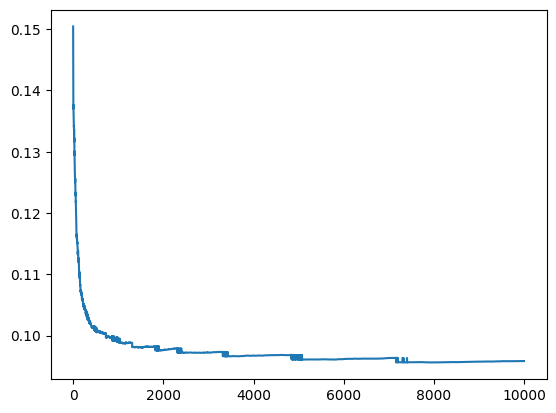

In [ ]:
plt.plot(range(P_max),obj)

The loss under gradient flow and the training loss on the gradient flow timescale (so that per unit time, one unit of gradient of the loss is taken).

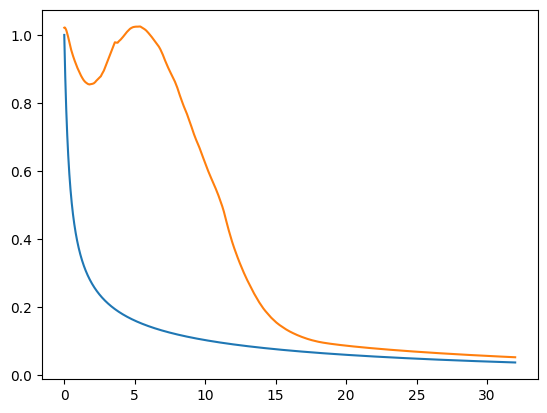

In [ ]:
plt.plot(tlist, input_loss)
plt.plot(tlist, Phi)

The plot below gives the stepsize schedule, also on gradient flow's time scale.

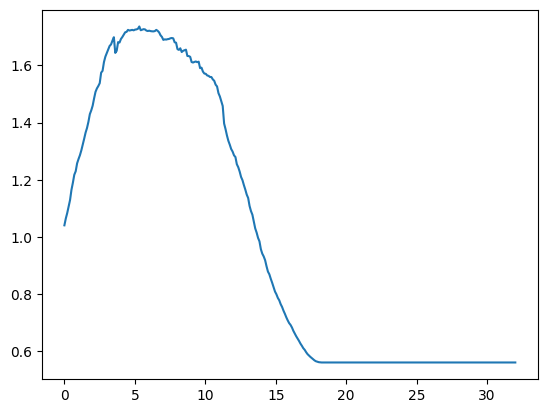

In [ ]:
plt.plot(np.linspace(0,R,R*w_res),1/w)

Generate plot of gradient flow + Psi, the loss in algorithm time.  This is what would be seen running SGD.

(0.0, 16.0)

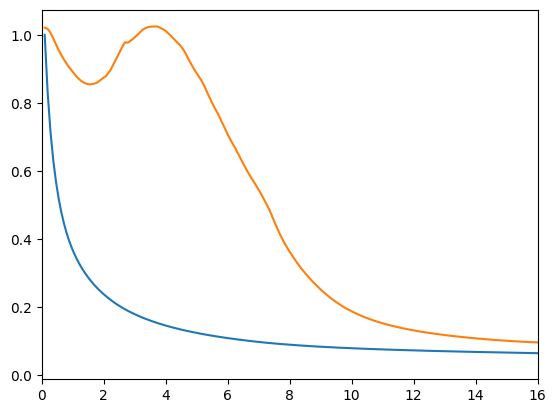

In [ ]:
gammainv = np.cumsum(w)
j = 0
#Gamma = 0
#for (idx,x) in enumerate(gammainv):
#  Psi.append(Gamma)
#  if x > j*w_res:
#    Psi.append(Phi[idx*loss_res//w_res])
#    j+=1
#    tindex = windex*loss_res//w_res
plt.plot(gammainv/w_res, input_loss[0::loss_res//w_res])
plt.plot(gammainv/w_res, Phi[0::loss_res//w_res])
#plt.yscale('log')
#plt.xscale('log')
plt.xlim((0,T))

Generate plot of gamma(t) (stepsize schedule in algorithm time)

(0.0, 16.0)

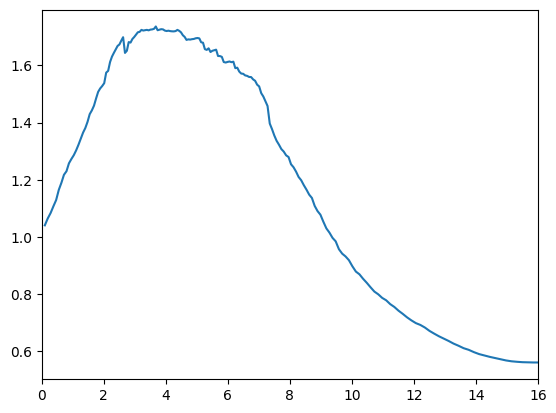

In [ ]:
plt.plot(gammainv/w_res, 1/w)
plt.xlim((0,T))

#Pinned Gradient-flow-odometer case

_This is the original method for generating optimal learning rate when the amount of gradient flow time is fixed._

In the following exercise, we will compute the optimal learning rate schedule (for training loss) by running SGD on the space of piecewise constant learning rates.  We start by fixing a time $T,$ which will be the length of time we would like to run the algorithm.  

We then let $R$ be the total amount of gradient flow time spent by the algorithm, and we optimize in the schedule $\Gamma(t)$, where
$$
\Gamma(T) = R \quad \text{and} \quad \Gamma(0) = 0,
$$
with the path of $\Gamma$ increasing.  We will let $R$ be fixed for the moment.  We then will work with the inverse function, and moreover its derivative $w = \tfrac{d}{ds} \Gamma^{-1}(s)$, in terms of which
$
\Phi(t) = \Psi_{\Gamma^{-1}(t)}
$
solves
$$
\Phi(t) = \mathcal{L}(\mathcal{X}_t) + \int_0^t \mathcal{K}(t-s)\frac{\Phi(s)}{w(s)}ds,
\quad
\mathcal{K}(t) = tr( (A^TA)^2 \exp(-2(A^TA + \delta)t)).
$$

So we divide time into epochs and consider a $w$ which is constant on epochs.  We would like to solve the minimization problem
$$
\text{argmin}_w \Phi(R; w).
$$

We will run SCD to generate the stepsize schedule.  We have divided w into epochs, and so we have a vector $w(k)$ where $k\in I = \{0,...,R-1\}$. The vector $w$ must always satisfy the summation condition
$$
\sum_k w(k) = T.
$$
At initialization, we take $w$ flat, meaning $w(k) = T/R$ for all $k \in I$.  Now we run SGD, meaning, we pick ${k,\ell}$ u.a.r, and we compute the gradient with respect to a perturbation of $w$ of the form
$$
\psi(k) = 1, \psi(\ell)=-1, \text{ and } \psi(j) = 0 \text{ otherwise}
$$
Now we compute the directional derivative in the $\psi$ direction
$$
\nabla_w \Phi(t) = \int_0^t \mathcal{K}(t-s)
\biggl(
  \frac{-\Phi(s)\psi(s)}{w^2(s)} + \frac{\nabla_w\Phi(s)}{w(s)}
\biggr)ds.
$$
Now we evaluate this at $t=R$ and then update in the $p$-th step
$$
w_{p+1} \leftarrow w_p - \aleph_p (\nabla_w \Phi(R)) \psi.
$$

*For simplification, we just use for the gradient flow loss the case where we solve for an isotropic gaussian target $b$.*

In [ ]:
#This assumes we have generated A, sgd_train_cs, t_max (which is T)
T=7
R=10 #500 t_max at gamma = 0.01
ridge=0.1
w_res = 10 #this is how many bins per epoch for w we use
loss_res = 100 #this is how many points per epoch we use for the numerical integration
tlist=np.linspace(0,R,R*loss_res)

#The input_loss is the loss under gradient flow.  The formula below is valid
#for solving for a setup where the target is isotropic normal,
#independent of the data matrix.
input_loss = np.sum([ np.exp(-2*(s+ridge)*tlist) for s in eigs ], axis=0)/n

#initialize w to be flat
w = np.ones(R*w_res) * (np.float64(T)/(R))

#how many loops to update
P_max = 5000

#generate K -- this includes the Delta-t factor for Riemann integration

K = np.zeros(R*loss_res)
K = np.sum([ s**2 * np.exp(-2*(s+ridge)*tlist) for s in eigs ], axis=0)/(n*loss_res)

#averaged knorm: this is the integral of (K(t)/w), with w the constant at initialization
knorm = (np.sum(K)*R)/T
loops = int(np.ceil(np.log(0.0001)/np.log(knorm)))
print( "will use {} iterations as knorm is {}".format(loops,knorm))

def wvolterra(forcing, w):
  output = np.zeros_like(forcing)
  for i in range(loops):
    output = forcing + fftconvolve(output/w, K, mode="full")[0:len(forcing)]
  return output

obj=[]

for p in range(P_max):
  Aleph_p = 100.0 #/(1+p)
  psi = np.random.choice(range(R*w_res),size=2,replace=False)

  wblowup = (np.array([w]).transpose()*np.ones((1,loss_res//w_res))).reshape(R*loss_res)

  Phi = wvolterra(input_loss,wblowup)

  #generating forcing term for gradient Volterra
  gforcea = -Phi/(wblowup**2)
  gforce = np.zeros_like(gforcea)
  gforce[
         (psi[0]*(loss_res//w_res)) : ((psi[0]+1)*(loss_res//w_res))
         ]=gforcea[
                   (psi[0]*(loss_res//w_res)) : ((psi[0]+1)*(loss_res//w_res))
                   ]
  gforce[
         (psi[1]*(loss_res//w_res)) : ((psi[1]+1)*(loss_res//w_res))
         ]=-1.0*gforcea[
                   (psi[1]*(loss_res//w_res)) : ((psi[1]+1)*(loss_res//w_res))
                   ]
  obj.append(Phi[-1])
  gforce = fftconvolve(gforce, K, mode="full")[0:len(gforcea)]

  #pass forcing term to Volterra
  grad = wvolterra(gforce,wblowup)

  g = grad[-1]

  #ensure that we don't subtract more than half of the minimum from the bins.
  maxwdelta = min(w[psi[0]], w[psi[1]])/2

  step = min(1,maxwdelta/np.abs(Aleph_p*g))

  w[psi[0]] -= Aleph_p*g*step
  w[psi[1]] += Aleph_p*g*step



#plt.plot(np.linspace(0,R,R*w_res),1/w)
plt.plot(range(P_max),obj)



will use 24 iterations as knorm is 0.6748975552974266


KeyboardInterrupt: ignored

This is the change in the objective function as a result of changing the schedule.

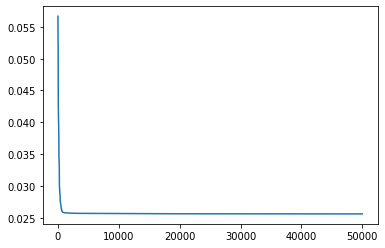

In [ ]:

plt.plot(range(P_max),obj)

The plot below is the loss under gradient flow (input_loss)

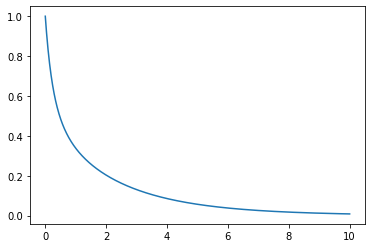

In [ ]:
plt.plot(tlist, input_loss)

The plot below gives the stepsize schedule

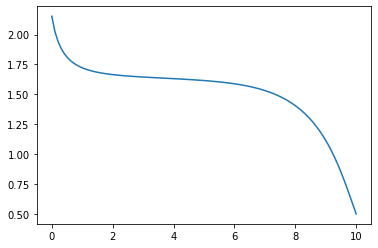

In [ ]:
plt.plot(np.linspace(0,R,R*w_res),1/w)